In [2]:
import preprocessing.preprocessing as pp
import torch
from models import baselines
import numpy as np
import evaluation.evaluation as ev
import training.training as tt
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.model_selection import ParameterGrid
import matplotlib.pyplot as plt
import networkx as nx
from scipy import stats
from torch_geometric.utils.convert import from_networkx

# Load the graphs

In [3]:
G_load = nx.read_gpickle("saved_data/graph_gt_pickle_upsamp")
L_load = pp.makeDual(G_load)

L05_train = nx.read_gpickle("saved_data/graph_L05_train_gt_pickle_upsamp")
L05_test = nx.read_gpickle("saved_data/graph_L05_test_gt_pickle_upsamp")

L05_train_torch = from_networkx(L05_train)
L05_test_torch = from_networkx(L05_test)


/home/laurin/.local/lib/python3.8/site-packages/torch_geometric/utils/convert.py:192: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:204.)
  data[key] = torch.tensor(value)


In [5]:
split_wholeG = nx.union(L05_train, L05_test)
# make the graph a torch obj
split_wholeG_torch = from_networkx(split_wholeG)
split_wholeG_y, _, _ =  pp.getLablesForDual(split_wholeG)

# normalizing the node features
xL_data = split_wholeG_torch.x.detach().numpy()
xL_data = xL_data[:, [0,1,2,3,4,5,6,7,8,9,10,11,12,15]]
#xL_data = (xL_data - np.median(xL_data, axis = 0)) / stats.median_abs_deviation(xL_data, axis = 0, scale = "normal")
xL_data = (xL_data - np.mean(xL_data, axis = 0)) / np.std(xL_data, axis = 0)
#xL_data = (xL_data - xL_data.min(0)) / xL_data.ptp(0)
#np.nan_to_num(xL_data, copy = False)
split_wholeG_torch.x = torch.tensor(xL_data)

# assign the right classes 
split_wholeG_torch.y = torch.tensor(split_wholeG_y)
geom_train_mask_torch = np.arange(0, L05_train.order())
geom_test_mask_torch = np.arange(L05_train.order(),L05_train.order()+ L05_test.order())

In [6]:
np.min(xL_data,axis = 0)


#np.max(split_wholeG_torch.x.detach().numpy(),axis = 0)

array([-1.06383028, -1.11825188, -0.3955092 , -0.82830895, -1.60274477,
       -7.7492151 , -7.75488609, -7.74804682, -7.75458536, -7.74251106,
       -7.75265736, -5.92267912, -7.2190037 , -1.01115514])

In [7]:

#define a grid Search function to find the optimal parameter setting
def gridSearch(model, data, grid_list):
    opt_mod = None
    max_acc = 0
    opt_bal_acc = 0
    for i, setting in enumerate(grid_list):
        clf = model(data,**setting)
        clf.fit(geom_train_mask_torch)
        pred_test = clf.predict(geom_test_mask_torch)
        acc = accuracy_score(clf.y[geom_test_mask_torch], pred_test)
        bal_acc = balanced_accuracy_score(clf.y[geom_test_mask_torch], pred_test)
        if acc > max_acc:
            max_acc = acc
            opt_mod = setting
            opt_bal_acc = bal_acc
    return opt_mod, max_acc, opt_bal_acc

# Random Forest

### Grid search for the optimal RF model

In [8]:

param_grid_rf = {'max_depth': [7, 8, 9, 10], 'max_features': ["sqrt", "log2"]}
grid_list_rf = list(ParameterGrid(param_grid_rf))


opt_mod_rf, max_acc_rf, opt_bal_acc_rf =  gridSearch(baselines.RandomForest, split_wholeG_torch, grid_list_rf)

print(opt_mod_rf)
print(max_acc_rf)
print(opt_bal_acc_rf)

{'max_depth': 7, 'max_features': 'sqrt'}
0.5508002783576896
0.45780942690038806


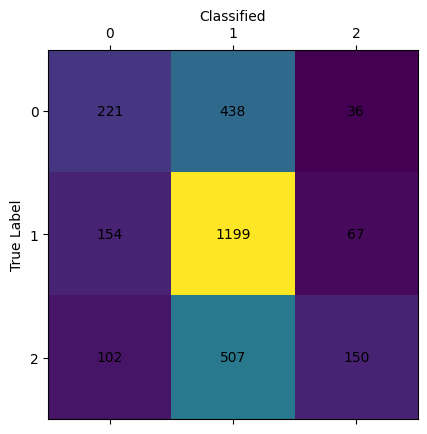

Test Set Accuracy and Balanced Accuracy
0.546276965901183
0.4533267557306379


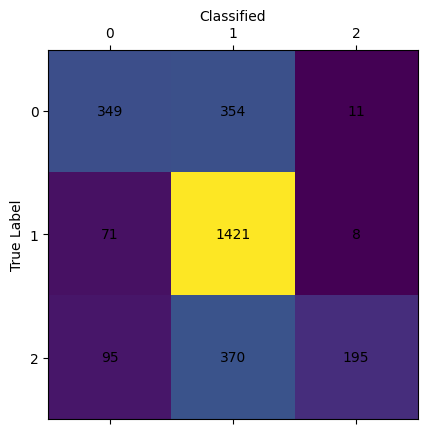

Training Set Accuracy and Balanced Accuracy
0.6837160751565762
0.577194465665054


In [9]:

clf_rf = baselines.RandomForest(split_wholeG_torch, **opt_mod_rf)

clf_rf.fit(geom_train_mask_torch)
pred_test = clf_rf.predict(geom_test_mask_torch)
pred_train = clf_rf.predict(geom_train_mask_torch)

ev.plot_confusion_matrix(clf_rf.y[geom_test_mask_torch], pred_test, [0,1,2])
#print(ev.eval_roc_auc(clf_rf.y[geom_test_mask_torch], pred_test))

print("Test Set Accuracy and Balanced Accuracy")
print(accuracy_score(clf_rf.y[geom_test_mask_torch], pred_test))
print(balanced_accuracy_score(clf_rf.y[geom_test_mask_torch], pred_test))


ev.plot_confusion_matrix(clf_rf.y[geom_train_mask_torch], pred_train, [0,1,2])
# extreme overfitting
print("Training Set Accuracy and Balanced Accuracy")
print(accuracy_score(clf_rf.y[geom_train_mask_torch], pred_train))
print(balanced_accuracy_score(clf_rf.y[geom_train_mask_torch], pred_train))



# Support Vector Machine

### Grid search for the optimal support vector machine model

In [12]:
param_grid_svc = {'C': [1, 100, 10000], 'kernel': ["linear", "rbf"]}
grid_list_svc = list(ParameterGrid(param_grid_svc))

opt_mod_svm, max_acc_svm, opt_bal_acc_svm =  gridSearch(baselines.SVM, split_wholeG_torch, grid_list_svc)

# {'C': 10000, 'kernel': 'linear'}
#0.5598039215686275
#0.44860112286408277

print(opt_mod_svm)
print(max_acc_svm)
print(opt_bal_acc_svm)

{'C': 100, 'kernel': 'rbf'}
0.5386221294363257
0.42702234360148683


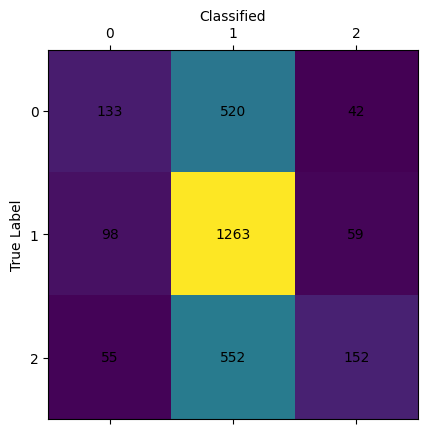

Test Set Accuracy and Balanced Accuracy
0.5386221294363257
0.42702234360148683


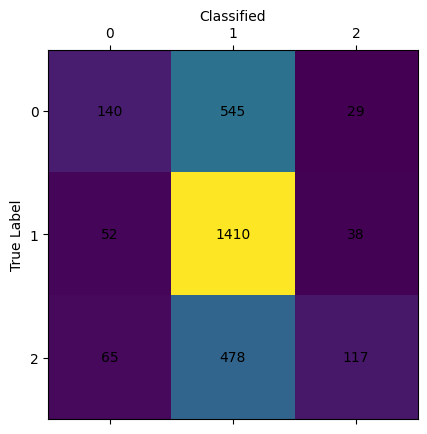

Training Set Accuracy and Balanced Accuracy
0.5800278357689631
0.4377837195484254


In [13]:
clf_svm = baselines.SVM(split_wholeG_torch,**opt_mod_svm)

clf_svm.fit(geom_train_mask_torch)
pred_test = clf_svm.predict(geom_test_mask_torch)
pred_train = clf_svm.predict(geom_train_mask_torch)

ev.plot_confusion_matrix(clf_svm.y[geom_test_mask_torch], pred_test, [0,1,2])
#print(ev.eval_roc_auc(clf_svm.y[geom_test_mask_torch], pred_test))

print("Test Set Accuracy and Balanced Accuracy")
print(accuracy_score(clf_svm.y[geom_test_mask_torch], pred_test))
print(balanced_accuracy_score(clf_svm.y[geom_test_mask_torch], pred_test))

ev.plot_confusion_matrix(clf_svm.y[geom_train_mask_torch], pred_train, [0,1,2])
# extreme overfitting
print("Training Set Accuracy and Balanced Accuracy")
print(accuracy_score(clf_svm.y[geom_train_mask_torch], pred_train))
print(balanced_accuracy_score(clf_svm.y[geom_train_mask_torch], pred_train))



# MLP

### Grid search for the optimal MLP model

/home/laurin/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


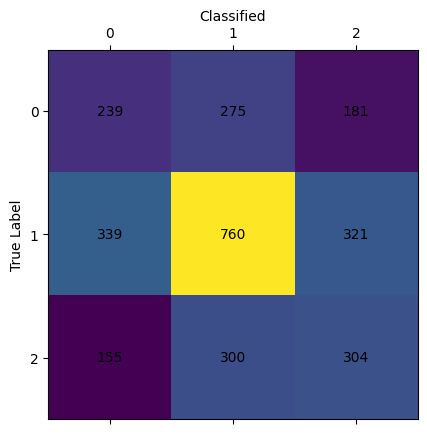

Test Set Accuracy and Balanced Accuracy
0.45337508698677803
0.4265410563048753


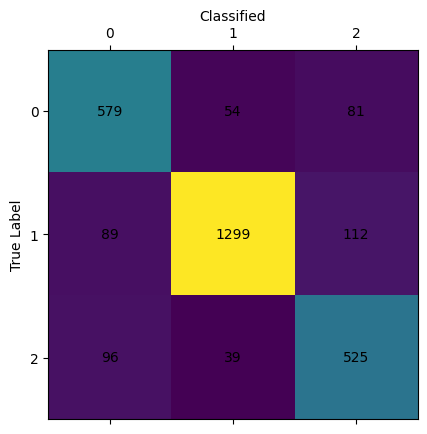

Training Set Accuracy and Balanced Accuracy
0.8361169102296451
0.8241263050674815


In [10]:
clf_mlp = baselines.MLP(split_wholeG_torch, max_iter = 3000, hidden_layer_sizes=(64,32,16),random_state=1234567, learning_rate = "adaptive", learning_rate_init = 0.01, tol =  -1)

clf_mlp.fit(geom_train_mask_torch)
pred_test = clf_mlp.predict(geom_test_mask_torch)
pred_train = clf_mlp.predict(geom_train_mask_torch)

ev.plot_confusion_matrix(clf_mlp.y[geom_test_mask_torch], pred_test, [0,1,2])
#print(ev.eval_roc_auc(clf_mlp.y[geom_test_mask_torch], pred_test))

print("Test Set Accuracy and Balanced Accuracy")
print(accuracy_score(clf_mlp.y[geom_test_mask_torch], pred_test))
print(balanced_accuracy_score(clf_mlp.y[geom_test_mask_torch], pred_test))

ev.plot_confusion_matrix(clf_mlp.y[geom_train_mask_torch], pred_train, [0,1,2])
# extreme overfitting
print("Training Set Accuracy and Balanced Accuracy")
print(accuracy_score(clf_mlp.y[geom_train_mask_torch], pred_train))
print(balanced_accuracy_score(clf_mlp.y[geom_train_mask_torch], pred_train))



14
[0 1 2]


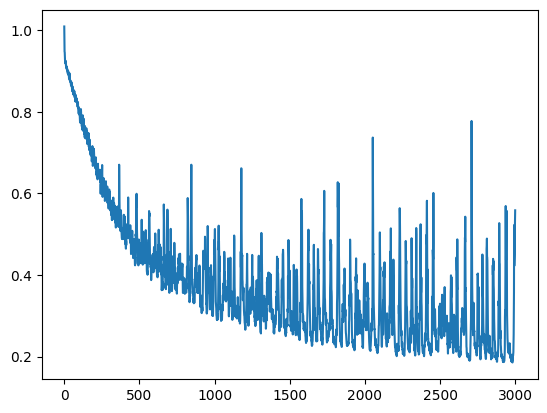

In [11]:
plt.plot(clf_mlp.clf.loss_curve_)
print(clf_mlp.clf.n_features_in_)
print(clf_mlp.clf.classes_)